<a href="https://colab.research.google.com/github/jurjoroa/DeepLearning_bias_NLP/blob/JorgeRoa/NN%20classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning using the bias data

Load functions

In [2]:
#########################################################################################################

# Define plot function to evaluate the model (plot accuracy and loss function during training)
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo-',marker=None)
    plt.plot(epochs, val_metrics, 'ro-',marker=None)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

#########################################################################################################

## Definition of the prediction distribution plot

def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fname=None):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
    legend={'race': [0,1], 'sex':[0,1]}
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0, 1]:
            ax = sns.distplot(y[Z[attr] == attr_val], hist=False,
                            kde_kws={'shade': True,},
                            label='{}'.format(legend[attr][attr_val]),
                            ax=axes[idx])
        ax.set_xlim(0,1)
        ax.set_ylim(0,7)
        ax.set_yticks([])
        ax.set_title("sensitive attibute: {}".format(attr))
        if idx == 0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{risk of recidiv}}|z_{{{}}})$'.format(attr))
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                        f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                        f"- Accuracy: {val_metrics['Accuracy']:.1f}"]),
                fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                    [f"- {attr}: {p_rules[attr]:.0f}%-rule"
                                    for attr in p_rules.keys()]),
                fontsize='16')
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    plt.legend()
    return fig

#########################################################################################################

# Define the FEED FORWARD NN to replicate similar result to COMPAS

def nn_classifier(n_features):
    inputs = Input(shape = (n_features,))
    dense1 = Dense(40, activation = 'relu')(inputs)
    dropout1 = Dropout(.4)(dense1)
    dense2 = Dense(40, activation = 'relu')(dropout1)
    dropout2 = Dropout(.3)(dense2)
    dense3 = Dense(32, activation = 'relu')(dropout2)
    dropout3 = Dropout(.3)(dense3)
    outputs = Dense(1, activation = 'sigmoid')(dropout3)
    model = Model(inputs = [inputs], outputs = [outputs])
    opt = Adam(learning_rate=0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
    return model

#########################################################################################################

# Definiton of the p% rule (FAIRNESS MEASURE)
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, roc_auc_score
from IPython import display
import numpy as np
np.random.seed(7)
import pandas as pd
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split




In [4]:
df_compas = pd.read_csv("https://raw.githubusercontent.com/jurjoroa/DeepLearning_bias_NLP/JorgeRoa/data_set.csv")


# One Hot encoding for categorical variable
charge_degree = pd.get_dummies(df_compas['charge_degree'])

charge_degree.columns = ['charge_degree_' + str(x) for x in charge_degree.columns]
df_compas = pd.concat([df_compas, charge_degree], axis=1)

df_compas.drop(['charge_degree'], axis=1, inplace=True)


X = df_compas.copy()

# Sensible attributes (we want to exclude them from training to avoid "intentional" bias)
Z_race = X.pop('race')
Z_sex = X.pop('sex')
Z_data = {'race': Z_race, 'sex': Z_sex}
Z = pd.concat(Z_data, axis = 1)

# Target: COMPAS risk prediction, 1 = Risk of recidivism, 0 = No risk
y = X.pop('target')

# Actual observed criminal activity reported within 2 years from compas score,
# 1 = the person committed a crime
# 0 = Not a recidivist
y_factual = X.pop('two_year_recid')
X.head()

np.random.seed(7)
X_train, X_test, y_train, y_test, y_factual_train, y_factual_test, Z_train, Z_test = train_test_split(X, y, y_factual, Z, test_size = 0.4,
                                                                    stratify = y, random_state = 7)
# Normalize the data
scaler = MinMaxScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns = df.columns, index = df.index)
X_train = X_train.pipe(scale_df, scaler)
X_test = X_test.pipe(scale_df, scaler)



Epoch 1/50
116/116 - 8s - loss: 0.6818 - accuracy: 0.5626 - val_loss: 0.6586 - val_accuracy: 0.6809 - 8s/epoch - 67ms/step
Epoch 2/50
116/116 - 1s - loss: 0.6368 - accuracy: 0.6439 - val_loss: 0.5728 - val_accuracy: 0.7069 - 517ms/epoch - 4ms/step
Epoch 3/50
116/116 - 1s - loss: 0.5765 - accuracy: 0.6997 - val_loss: 0.5320 - val_accuracy: 0.7256 - 503ms/epoch - 4ms/step
Epoch 4/50
116/116 - 0s - loss: 0.5631 - accuracy: 0.7160 - val_loss: 0.5411 - val_accuracy: 0.7191 - 492ms/epoch - 4ms/step
Epoch 5/50
116/116 - 1s - loss: 0.5510 - accuracy: 0.7247 - val_loss: 0.5266 - val_accuracy: 0.7280 - 501ms/epoch - 4ms/step
Epoch 6/50
116/116 - 0s - loss: 0.5397 - accuracy: 0.7325 - val_loss: 0.5254 - val_accuracy: 0.7309 - 488ms/epoch - 4ms/step
Epoch 7/50
116/116 - 1s - loss: 0.5500 - accuracy: 0.7228 - val_loss: 0.5313 - val_accuracy: 0.7272 - 513ms/epoch - 4ms/step
Epoch 8/50
116/116 - 1s - loss: 0.5412 - accuracy: 0.7285 - val_loss: 0.5261 - val_accuracy: 0.7268 - 981ms/epoch - 8ms/step
Ep

<ipython-input-2-ced0f398b742>:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, train_metrics, 'bo-',marker=None)
<ipython-input-2-ced0f398b742>:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, val_metrics, 'ro-',marker=None)


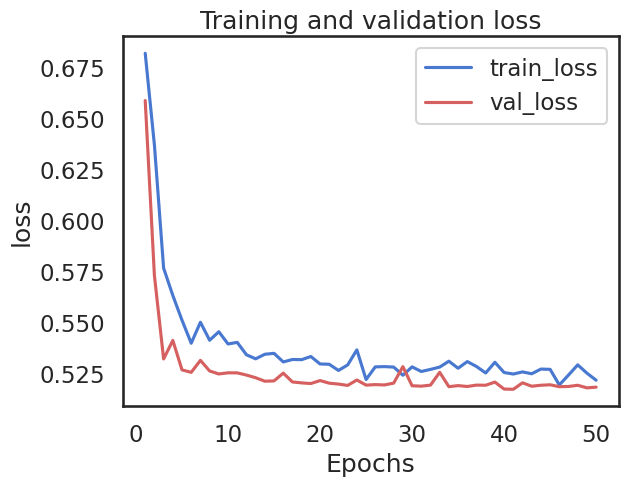

In [5]:


### FIT THE MODEL
np.random.seed(7)
clf_1 = nn_classifier(n_features = X_train.shape[1])
history = clf_1.fit(X_train, y_train.values, epochs = 50, verbose = 2,validation_data = (X_test, y_test))

plot_metric(history, 'loss')

In [28]:
clf_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

<ipython-input-47-708e3bf9322e>:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, train_metrics, 'bo-',marker=None)
<ipython-input-47-708e3bf9322e>:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, val_metrics, 'ro-',marker=None)


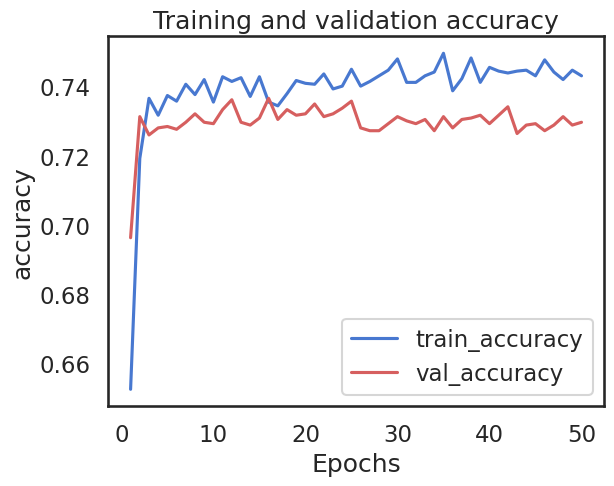

In [50]:
plot_metric(history, 'accuracy')

In [37]:
import keras_tuner as kt
from keras import Input, Model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

def nn_classifier(hp, n_features):
    inputs = Input(shape=(n_features,))
    x = inputs

    # Tuning the number of units in the first dense layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    x = Dense(units=hp_units1, activation='relu')(x)
    hp_dropout1 = hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)
    x = Dropout(rate=hp_dropout1)(x)

    # Tuning the number of units in the second dense layer
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    x = Dense(units=hp_units2, activation='relu')(x)
    hp_dropout2 = hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)
    x = Dropout(rate=hp_dropout2)(x)

    # Tuning the number of units in the third dense layer
    hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    x = Dense(units=hp_units3, activation='relu')(x)
    hp_dropout3 = hp.Float('dropout3', min_value=0.0, max_value=0.5, step=0.1)
    x = Dropout(rate=hp_dropout3)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Tuning the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [39]:
def build_model(hp):
    return nn_classifier(hp, n_features=X_train.shape[1])

# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    directory='keras_tuner',
    project_name='nn_tuning',
    factor=3,
    hyperband_iterations=2
)


In [42]:
# Create a callback to stop training early after reaching a certain value for the validation loss
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Execute the hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')}, in the second layer is {best_hps.get('units2')}, and in the third layer is {best_hps.get('units3')}.
The optimal dropout rates are {best_hps.get('dropout1')}, {best_hps.get('dropout2')}, and {best_hps.get('dropout3')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Trial 180 Complete [00h 00m 37s]
val_accuracy: 0.7337398529052734

Best val_accuracy So Far: 0.7394309043884277
Total elapsed time: 00h 25m 21s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 352, in the second layer is 416, and in the third layer is 96.
The optimal dropout rates are 0.30000000000000004, 0.30000000000000004, and 0.0.
The optimal learning rate for the optimizer is 0.001.

Epoch 1/50
116/116 [==============================] - 2s 8ms/step - loss: 0.5901 - accuracy: 0.6840 - val_loss: 0.5367 - val_accuracy: 0.7159
Epoch 2/50
116/116 [==============================] - 1s 5ms/step - loss: 0.5396 - accuracy: 0.7244 - val_loss: 0.5328 - val_accuracy: 0.7297
Epoch 3/50
116/116 [==============================] - 1s 7ms/step - loss: 0.5311 - accuracy: 0.7325 - val_loss: 0.5219 - val_accuracy: 0.7321
Epoch 4/50
116/116 [==============================] - 1s 5ms/step - loss: 0.5306 - accuracy: 0.7347 - val_loss: 0.5255 - va

77/77 [==============================] - 0s 2ms/step
Accuracy: 72.9%


<ipython-input-2-ced0f398b742>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y[Z[attr] == attr_val], hist=False,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-2-ced0f398b742>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kde

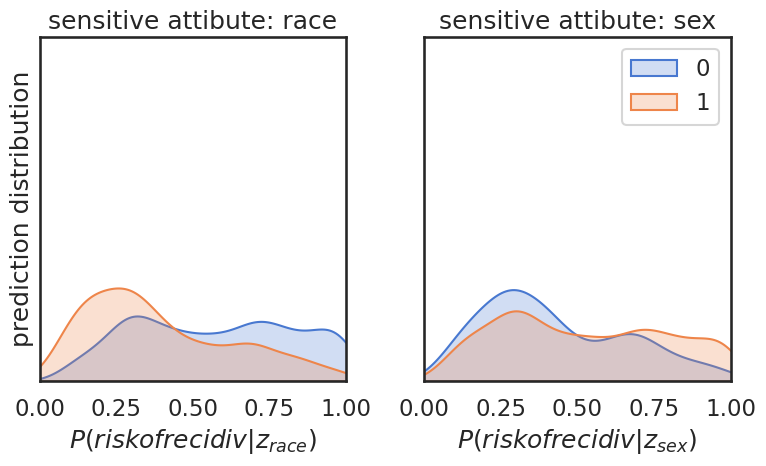

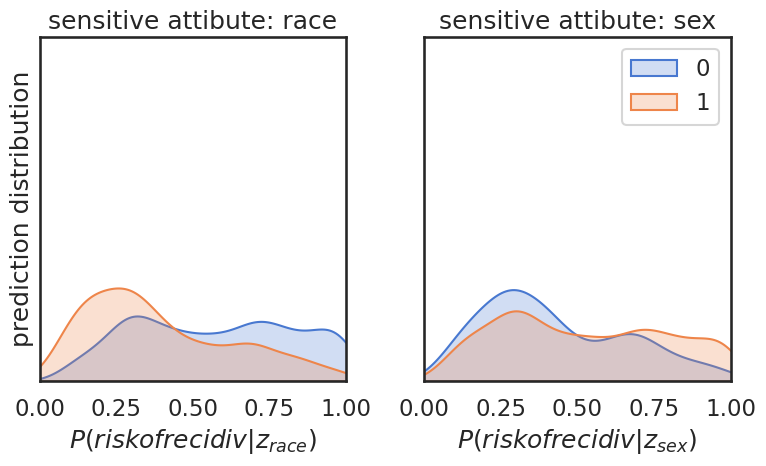

In [6]:

# PREDICTIONS
y_pred_1 = pd.Series(clf_1.predict(X_test).ravel(), index=y_test.index)
print(f"Accuracy: {100*accuracy_score(y_test, (y_pred_1>0.5)):.1f}%")

plot_distributions(y_pred_1, Z_test)


In [7]:

print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred_1, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred_1, Z_test['sex']):.0f}%-rule")


The classifier satisfies the following %p-rules:
	given attribute race; 53%-rule
	given attribute sex;  67%-rule
